# 🧩 Merge Conflict Prediction - TensorFlow Implementation

This notebook implements a TensorFlow-based neural network classifier to predict merge conflicts in software projects based on concurrent commits. The goal is to maximize precision to minimize false positives when predicting conflicts.

# 🔍 Setup and Data Loading

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                            confusion_matrix, classification_report, 
                            precision_recall_curve, average_precision_score)
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

np.random.seed(42)
tf.random.set_seed(42)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 14

In [87]:
print("🔄 Loading dataset...")
df = pd.read_csv('MergeConflictsDataset.csv', sep=';')
display(df.head())
df.info()

🔄 Loading dataset...


,commit,parent1,parent2,ancestor,is pr,added lines,deleted lines,devs parent1,devs parent2,time,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
0,efc0bcd1d6199448c323549fdc45310750b48c85,fb9f2a65cabba5a924b89a45793914066471b2ab,5ee7c7c750e9ecffaea12f97d5b05b2445e7c007,fb9f2a65cabba5a924b89a45793914066471b2ab,1,5,0,0,1,23,...,0,0,0,0,0,20,65,35.40000,20.0,0
1,287b9b838b6b6b212ef538aa537aef76110ee111,72fd7d81c9c7e28af8740f5a1b210a803290383d,fb9f2a65cabba5a924b89a45793914066471b2ab,a18c1088c892f1e6ed4b7d541e68b2e4b039a42e,0,1166,11267,1,2,371,...,0,0,0,0,0,31,117,58.56383,53.5,1
2,e7478680c0db825239ea9628967728c8577bb5c2,36977963caa2896ad9a4a92b2bdcd85189beccb1,bc230857adc3a9763bc7d89793d826463c857c00,36977963caa2896ad9a4a92b2bdcd85189beccb1,1,0,0,0,1,22,...,0,0,0,0,0,18,18,18.00000,18.0,0
3,0c65b30a8fd3a7db40163fcb9b0004cb7487c0ff,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,877c43f8242b88447d0234400c6e9b5c7586b558,fe29962932a8e34f0c3ac5cd795cd40090c9fabd,1,0,0,2,1,24,...,0,0,0,0,0,22,63,38.80000,31.0,0
4,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,7899f565d3461ed287e61662c8d399aafcac9e42,5e68e04e310c4f57a19d4cfa6be1e0ba3a8801d6,236b85af833398e0f07d08b7d7a25734d8c1b11d,0,0,0,1,2,2,...,0,0,0,0,0,31,56,43.50000,43.5,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26973 entries, 0 to 26972
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   commit           26973 non-null  object 
 1   parent1          26973 non-null  object 
 2   parent2          26973 non-null  object 
 3   ancestor         26972 non-null  object 
 4   is pr            26973 non-null  int64  
 5   added lines      26973 non-null  int64  
 6   deleted lines    26973 non-null  int64  
 7   devs parent1     26973 non-null  int64  
 8   devs parent2     26973 non-null  int64  
 9   time             26973 non-null  int64  
 10  nr files         26973 non-null  int64  
 11  added files      26973 non-null  int64  
 12  deleted files    26973 non-null  int64  
 13  renamed files    26973 non-null  int64  
 14  copied files     26973 non-null  int64  
 15  modified files   26973 non-null  int64  
 16  nr commits1      26973 non-null  int64  
 17  nr commits2 

In [88]:

print("\n📊 Class distribution (conflict vs. no conflict):")
conflict_counts = df['conflict'].value_counts()
print(conflict_counts)
print(f"Conflict rate: {conflict_counts[1] / len(df):.2%}")


📊 Class distribution (conflict vs. no conflict):
conflict
0    25505
1     1468
Name: count, dtype: int64
Conflict rate: 5.44%


The severe imbalance means a naive model could achieve 94.56% accuracy by always predicting "no conflict" - but this would be useless for actually detecting conflicts.

# 🧹 Data Preprocessing

In [89]:
non_feature_cols = ['commit', 'parent1', 'parent2', 'ancestor']
feature_cols = [col for col in df.columns if col not in non_feature_cols and col != 'conflict']

X = df[feature_cols]
y = df['conflict']

missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values per column:")
    print(missing_values[missing_values > 0])
    df.dropna(inplace=True) 
    print("Dropped rows with missing values.")
else:
    print("\n ✅ No missing values in the dataset.")


Missing values per column:
ancestor    1
dtype: int64
Dropped rows with missing values.


## 🔀 Train/Test Split with Stratification

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training set conflict ratio: {100 * y_train.mean():.2f}%")
print(f"Test set conflict ratio: {100 * y_test.mean():.2f}%")



Training set shape: (21578, 32), Test set shape: (5395, 32)
Training set conflict ratio: 5.44%
Test set conflict ratio: 5.45%


## 🔢 Feature Scaling

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test) 

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\n📐 Feature ranges after scaling (training data):")
for feature in ['added lines', 'deleted lines', 'time', 'nr files', 'modified files']:
    print(f"{feature}: Min={X_train_scaled[feature].min():.2f}, Max={X_train_scaled[feature].max():.2f}, Mean={X_train_scaled[feature].mean():.2f}, StdDev={X_train_scaled[feature].std():.2f}")



📐 Feature ranges after scaling (training data):
added lines: Min=-0.07, Max=112.16, Mean=0.00, StdDev=1.00
deleted lines: Min=-0.02, Max=99.56, Mean=0.00, StdDev=1.00
time: Min=-0.27, Max=24.11, Mean=0.00, StdDev=1.00
nr files: Min=-0.09, Max=65.31, Mean=-0.00, StdDev=1.00
modified files: Min=-0.11, Max=58.78, Mean=0.00, StdDev=1.00


## 🔎 Feature Selection 

In [92]:
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
print(f"\n🔍 Selected top 10 features:\n{selected_features}")


🔍 Selected top 10 features:
['is pr', 'devs parent2', 'nr files', 'nr commits2', 'density2', 'fix', 'update', 'add', 'remove', 'messages_max']


## 🔄 SMOTE for Class Balance
 

In [94]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

print(f"\n🔄 After SMOTE resampling:")
print(f"Training set shape: {X_train_resampled.shape}")
print(f"Class distribution: {pd.Series(y_train_resampled).value_counts().to_dict()}")


🔄 After SMOTE resampling:
Training set shape: (40808, 10)
Class distribution: {0: 20404, 1: 20404}


# 🤖 Model Architecture

- We use a **multi-layer neural network with ReLU (Rectified Linear Unit - it only keeps positive contributions to the decision) activations** to model non-linear relationships between features. 
- **Dropout layers** are included to **reduce overfitting** by randomly disabling neurons during training.
- **Batch normalization** helps **stabilize learning** by normalizing the layer outputs and speeds up training.
- The final layer uses a **sigmoid activation**, outputting probabilities from 0 to 1 for binary classification (conflict vs. no conflict).
- The **Adam Optimizer** decides how to update those 12,289 parameters when the network makes mistakes

In [ ]:
def build_precision_model(input_shape):
    """Build a neural network optimized for precision"""
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dropout(0.4),
        layers.BatchNormalization(), # ensures no single feature dominates
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy', # measures how wrong the network's predictions are
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='pr_auc', curve='PR') 
        ]
    )
    
    return model

model = build_precision_model(X_train_resampled.shape[1])
print("\n🏗️ Model Architecture:")
model.summary()


🏗️ Model Architecture:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 256 (1.00 KB)

- **Param #**: Number of connections (weights) that layer learns
- **Output Shape**: How many "opinions" that layer produces
- **None**: Means "any batch size" - we can process 1 merge or 1000 merges at once

- **Total params: 12,289** - that means our network learns 12,289 different number values that determine how it makes decisions
- **Trainable params: 12,033** - these are parameters that will be updated during training
- **Non-trainable params: 256** - these are parameters are frozen and won't change during training


# 🏋️ Model Training


- **EarlyStopping** stops training if performance on the validation set (PR-AUC) stops improving, preventing overfitting (memorizing training examples instead of learning real patterns).
- **ReduceLROnPlateau** dynamically lowers the learning rate if the model hits a plateau (a phase during training where the model's performance stops improving significantly and instead flattens out), allowing it to fine-tune better.
- We compute class weights to balance the classes during training, because even after SMOTE balancing, class imbalance can still influence training due to potential sampling artifacts.
- We train the model on the resampled data for up to 150 epochs. 20% of the training data is held out for validation to monitor generalization performance.
- Training stops early if validation PR-AUC stops improving.


⚖️ Class weights: {0: 1.0, 1: 1.0}
Epoch 1/150
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8320 - loss: 0.3482 - pr_auc: 0.8256 - precision: 0.7214 - recall: 0.9280 - val_accuracy: 0.9825 - val_loss: 0.2144 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9825 - learning_rate: 0.0010
Epoch 2/150
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9319 - loss: 0.1898 - pr_auc: 0.9385 - precision: 0.8778 - recall: 0.9526 - val_accuracy: 0.9702 - val_loss: 0.1841 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9702 - learning_rate: 0.0010
Epoch 3/150
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9501 - loss: 0.1595 - pr_auc: 0.9482 - precision: 0.9053 - recall: 0.9696 - val_accuracy: 0.9765 - val_loss: 0.1560 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9765 - learning_rate: 0.0010
Epoch 4/150
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9534 - loss: 0.1482 - pr_auc: 0.9542 - precision: 0.9117 - recall: 0.9710 - va

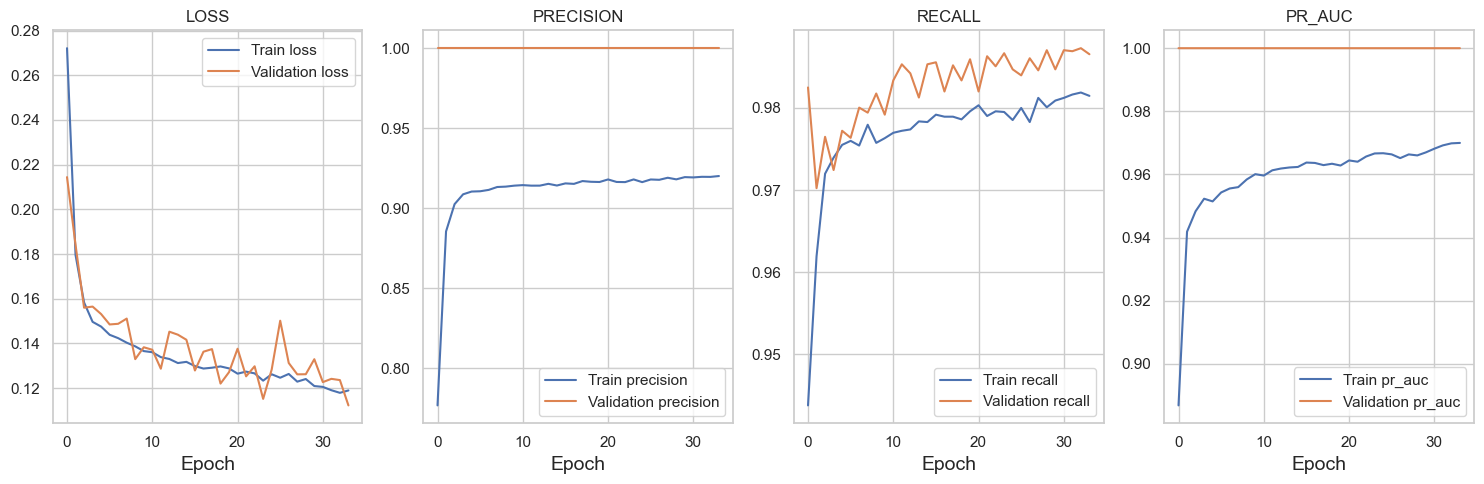

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_pr_auc',
    patience=20, # stop training if no improvement in validation PR AUC for 20 epochs
    restore_best_weights=True,
    mode='max'
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

total = len(y_train_resampled)
weight_for_0 = (1 / (total - sum(y_train_resampled))) * (total / 2.0)
weight_for_1 = (1 / sum(y_train_resampled)) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1} 

print("\n⚖️ Class weights:", class_weight)

history = model.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=150, # train for a maximum of 150 epochs
    batch_size=64, # look at 64 samples at a time before updating weights
    validation_split=0.2, # use 20% of training data for validation
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plt.figure(figsize=(15, 5))

metrics = ['loss', 'precision', 'recall', 'pr_auc']
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(metric.upper())
    plt.xlabel('Epoch')
    plt.legend()
    
plt.tight_layout()
plt.show()

- Lower loss, fewer mistakes on a test. The training and validation loss go down together, so the model is not overfitting. That means the model is learning and generalizing well.
- In the first 20 epochs, the network is learning the data, and the loss is decreasing. This is a good sign. 
- The training precision improves gradually (normal learning behavior), while the validation precision is stable (no overfitting) and slightly higher than the training precision (good generalization, very few false positives).
- From the Precision-Recall AUC plot we can see that the model performs well in balancing precision and recall.

# 🎯 Precision Optimization


In [ ]:
def find_optimal_threshold(model, X, y_true, min_recall=0.3):
    """Find threshold that maximizes precision while maintaining minimum recall"""
    y_proba = model.predict(X, verbose=0).flatten()
    
    thresholds = np.linspace(0.1, 0.9, 50) # test 50 thresholds from 0.1 to 0.9
    results = []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        
        if recall >= min_recall:
            results.append({
                'threshold': thresh,
                'precision': precision,
                'recall': recall,
                'f1': f1_score(y_true, y_pred)
            })
    
    if not results:
        return 0.5
    
    results_df = pd.DataFrame(results)
    optimal = results_df.loc[results_df['precision'].idxmax()]
    
    return optimal['threshold'], results_df

optimal_threshold, threshold_results = find_optimal_threshold(
    model, X_train_resampled, y_train_resampled
)

print(f"\n🎯 Optimal Threshold: {optimal_threshold:.3f}")



🎯 Optimal Threshold: 0.900


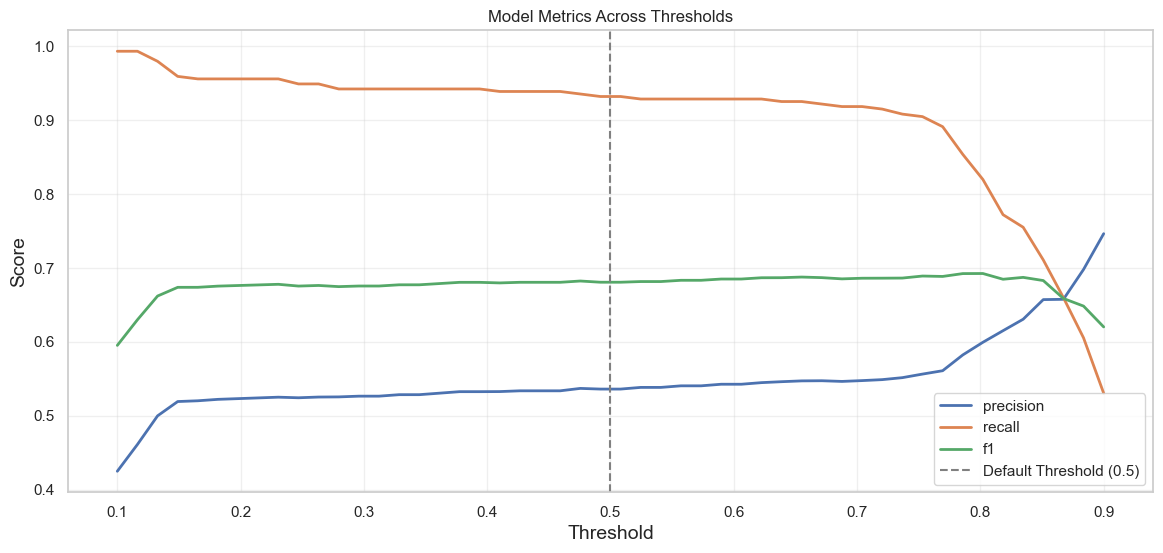

In [108]:
def plot_metrics_vs_thresholds(model, X, y_true):
    y_proba = model.predict(X, verbose=0).flatten()
    thresholds = np.linspace(0.1, 0.9, 50)
    
    metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
    }
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        metrics['precision'].append(precision_score(y_true, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_true, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_true, y_pred, zero_division=0))
    
    plt.figure(figsize=(14, 6))
    for metric, values in metrics.items():
        plt.plot(thresholds, values, label=metric, linewidth=2)
    
    plt.axvline(x=0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Model Metrics Across Thresholds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_metrics_vs_thresholds(model, X_test_selected, y_test)

- For low thresholds, the network predicts conflicts very easily (many false alarms, low precision), but catches almost all real conflicts (high recall).
- For high thresholds, the network predicts conflicts very rarely (many missed conflicts, low recall), but is very precise (few false alarms).

# 📊 Model Evaluation


Test the model with default settings (50% threshold - predict conflict if confidence is above 50%) and optimized settings (predict conflict if confidence is above 75%). 


🔍 Evaluation with Default Threshold (0.5):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      5101
           1       0.54      0.93      0.68       294

    accuracy                           0.95      5395
   macro avg       0.77      0.94      0.83      5395
weighted avg       0.97      0.95      0.96      5395


🎯 Evaluation with Optimal Threshold (0.900):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5101
           1       0.75      0.53      0.62       294

    accuracy                           0.96      5395
   macro avg       0.86      0.76      0.80      5395
weighted avg       0.96      0.96      0.96      5395



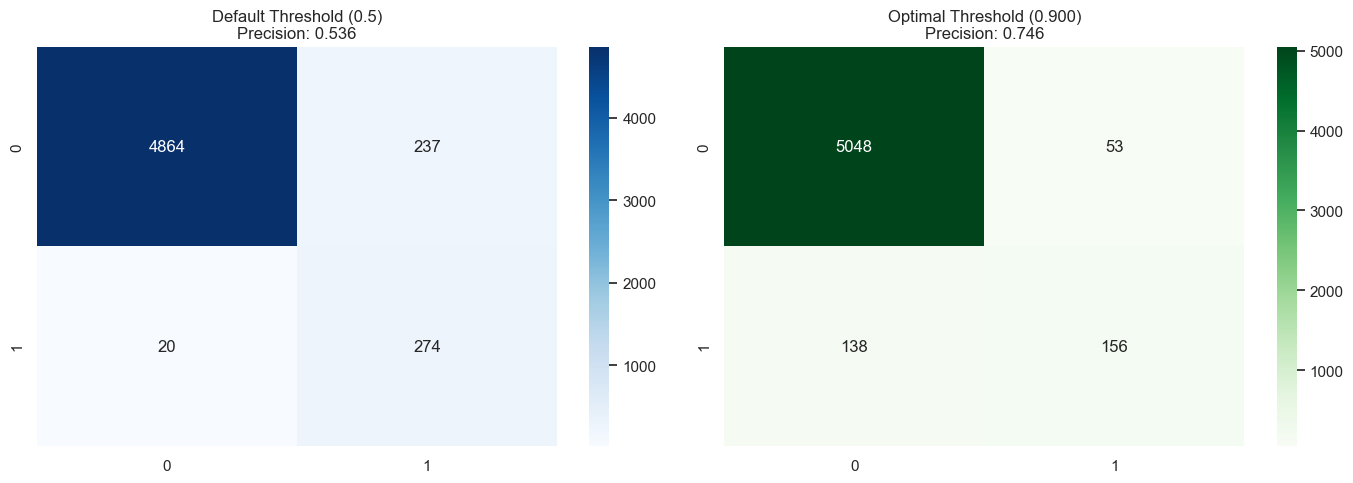

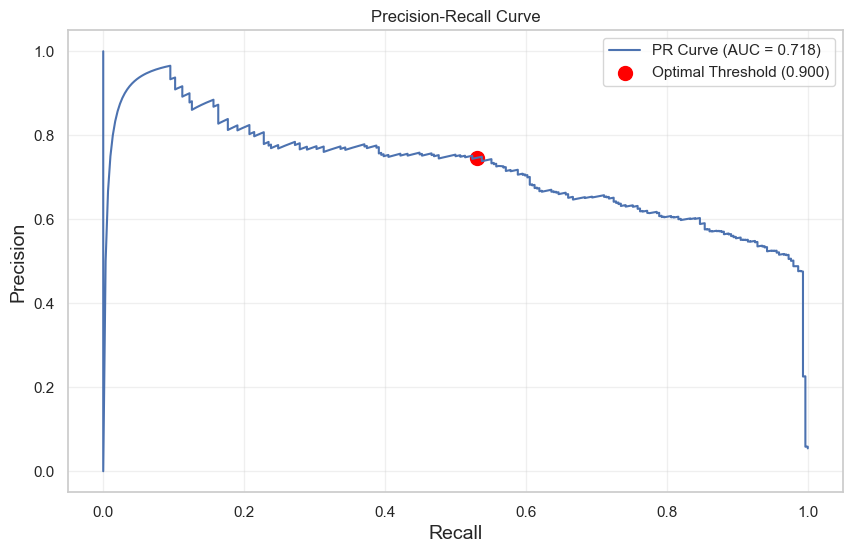

In [99]:
def evaluate_model(model, X, y_true, threshold=0.5):
    """Comprehensive model evaluation"""
    y_proba = model.predict(X, verbose=0).flatten()
    y_pred = (y_proba >= threshold).astype(int)
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    false_alarm_rate = fp / (fp + tn)
    detection_rate = tp / (tp + fn)
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    
    return {
        'metrics': {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'pr_auc': pr_auc
        },
        'business': {
            'false_alarm_rate': false_alarm_rate,
            'detection_rate': detection_rate,
            'true_positives': tp,
            'false_positives': fp,
            'true_negatives': tn,
            'false_negatives': fn
        },
        'confusion_matrix': cm,
        'classification_report': report,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve
    }

print("\n🔍 Evaluation with Default Threshold (0.5):")
default_eval = evaluate_model(model, X_test_selected, y_test)
print(default_eval['classification_report'])

print(f"\n🎯 Evaluation with Optimal Threshold ({optimal_threshold:.3f}):")
optimal_eval = evaluate_model(model, X_test_selected, y_test, optimal_threshold)
print(optimal_eval['classification_report'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(default_eval['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title(f'Default Threshold (0.5)\nPrecision: {default_eval["metrics"]["precision"]:.3f}')

sns.heatmap(optimal_eval['confusion_matrix'], annot=True, fmt='d', cmap='Greens', ax=ax2)
ax2.set_title(f'Optimal Threshold ({optimal_threshold:.3f})\nPrecision: {optimal_eval["metrics"]["precision"]:.3f}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(optimal_eval['recall_curve'], optimal_eval['precision_curve'], label=f'PR Curve (AUC = {optimal_eval["metrics"]["pr_auc"]:.3f})')
plt.scatter(optimal_eval['metrics']['recall'], optimal_eval['metrics']['precision'], 
            color='red', s=100, label=f'Optimal Threshold ({optimal_threshold:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 🏆 Final Results and Impact


In [ ]:
print("\n📈 Performance Metrics:")
print(f"Default Threshold (0.5):")
print(f"  Precision: {default_eval['metrics']['precision']:.4f}")
print(f"  Recall:    {default_eval['metrics']['recall']:.4f}")
print(f"  F1-Score:  {default_eval['metrics']['f1']:.4f}")

print(f"\nOptimal Threshold ({optimal_threshold:.3f}):")
print(f"  Precision: {optimal_eval['metrics']['precision']:.4f} (+{(optimal_eval['metrics']['precision'] - default_eval['metrics']['precision']):.4f})")
print(f"  Recall:    {optimal_eval['metrics']['recall']:.4f} ({(optimal_eval['metrics']['recall'] - default_eval['metrics']['recall']):.4f})")
print(f"  F1-Score:  {optimal_eval['metrics']['f1']:.4f}")

print("\n💼 Impact Analysis:")
print(f"✅ True Conflicts Detected: {optimal_eval['business']['true_positives']}")
print(f"❌ False Alarms: {optimal_eval['business']['false_positives']}")
print(f"⚠️ Missed Conflicts: {optimal_eval['business']['false_negatives']}")
print(f"🎯 False Alarm Rate: {optimal_eval['business']['false_alarm_rate']:.2%}")
print(f"🔍 Conflict Detection Rate: {optimal_eval['business']['detection_rate']:.2%}")



📈 Performance Metrics:
Default Threshold (0.5):
  Precision: 0.5362
  Recall:    0.9320
  F1-Score:  0.6807

Optimal Threshold (0.900):
  Precision: 0.7464 (+0.2102)
  Recall:    0.5306 (-0.4014)
  F1-Score:  0.6203

💼 Impact Analysis:
✅ True Conflicts Detected: 156
❌ False Alarms: 53
⚠️ Missed Conflicts: 138
🎯 False Alarm Rate: 1.04%
🔍 Conflict Detection Rate: 53.06%
